In [15]:
import numpy as np
import pandas as pd
import matplotlib as plt

from darts.models import LightGBMModel, RandomForest, XGBModel
from darts import TimeSeries, concatenate
from darts.metrics import rmse
from darts.utils.timeseries_generation import datetime_attribute_timeseries
plt.rcParams.update({'figure.figsize':(18,10), 'figure.dpi':120})

import optuna
from optuna.visualization import (
    plot_optimization_history,
    plot_contour,
    plot_param_importances,
)

In [2]:
df = pd.read_csv(r'electricityDailyLoad.csv')
df['dt'] = pd.to_datetime(df['dt'])
df.sort_values(by='dt', inplace=True)
df.drop_duplicates(subset=["dt"], keep='first', inplace=True)

In [80]:
series = TimeSeries.from_dataframe(df, "dt","Load")

train_val, test = series.split_before(pd.Timestamp("20190101"))
train, val = train_val.split_before(pd.Timestamp("20180101"))

In [4]:
# create month and year covariate series
year_series = datetime_attribute_timeseries(
    #pd.date_range(start=series.start_time(), freq=series.freq_str, periods=len(series)+365),
    series,
    attribute="year",
    one_hot=False,
)

day_series = datetime_attribute_timeseries(
    year_series, attribute="dayofyear", one_hot=False
)

weekday_series = datetime_attribute_timeseries(
    year_series, attribute="dayofweek", one_hot=False
)

covariates = year_series.stack(day_series)
covariates = covariates.stack(weekday_series)

In [42]:
# function to calc RMSE; and also plot results
def eval_results(model):
    backtest = model.historical_forecasts(
        series,
        future_covariates=covariates,
        start=pd.Timestamp("20190101"),
        forecast_horizon=30,
        stride=30,
        last_points_only = False,
        retrain=False,
        verbose=True
    )

    forecast = concatenate(backtest)
    forecast.plot(label="forecast")
    test.plot()
    print("Total error (RMSE) over all historical forecasts: %.2f" % rmse(test,forecast))

    error=[]
    for i in range(0,12):
        error.append(rmse(forecast[i*30:i*30+30], test[i*30:i*30+30]))

    average_error = np.mean(error)
    print("Average error (RMSE) over all historical forecasts: %.2f" % average_error)

In [6]:
LGBModel = LightGBMModel(
    lags=7,
    lags_future_covariates=(7,1),
    output_chunk_length=1,
    random_state=0,
)


LGBModel.fit(
    train,
    future_covariates=covariates,
    verbose=True,
)

  0%|          | 0/12 [00:00<?, ?it/s]

Total error (RMSE) over all historical forecasts: 5200.50
Average error (RMSE) over all historical forecasts: 5042.66


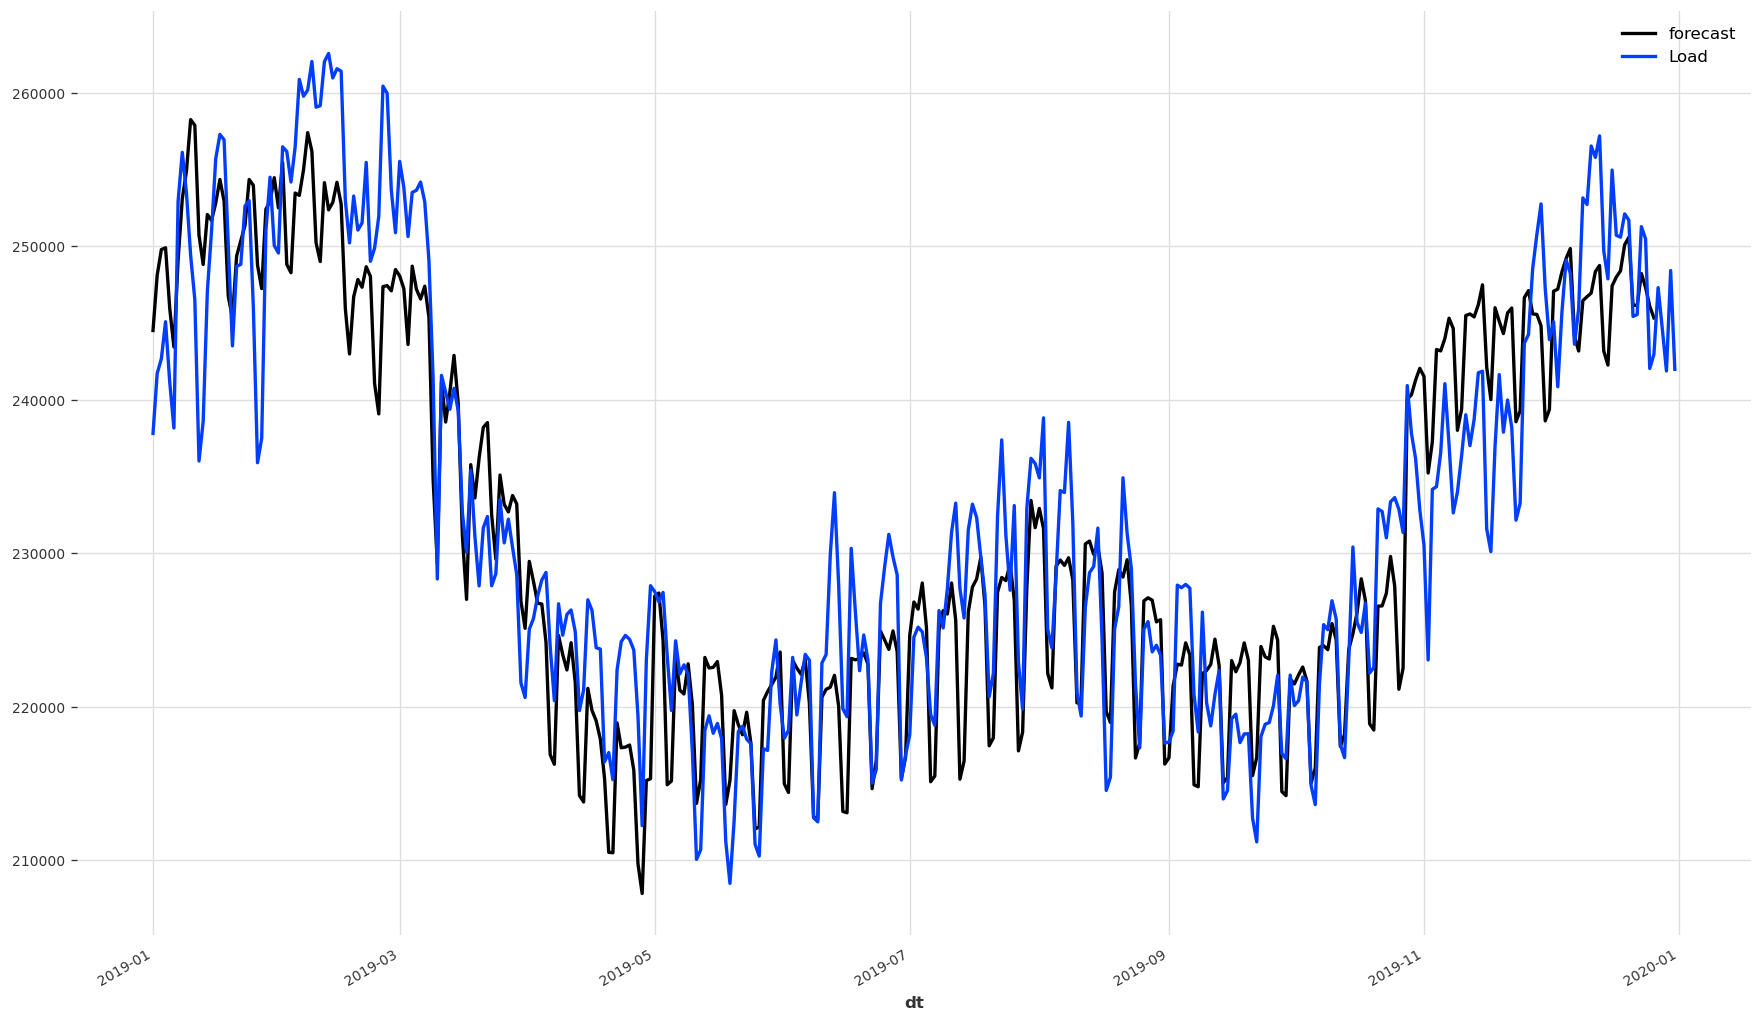

In [7]:
eval_results(LGBModel)

In [8]:
RF = RandomForest(
    lags=7,
    lags_future_covariates=(7,1),
    output_chunk_length=1,
)


RF.fit(
    train,
    future_covariates=covariates,
)

  0%|          | 0/12 [00:00<?, ?it/s]

Total error (RMSE) over all historical forecasts: 7500.17
Average error (RMSE) over all historical forecasts: 7164.81


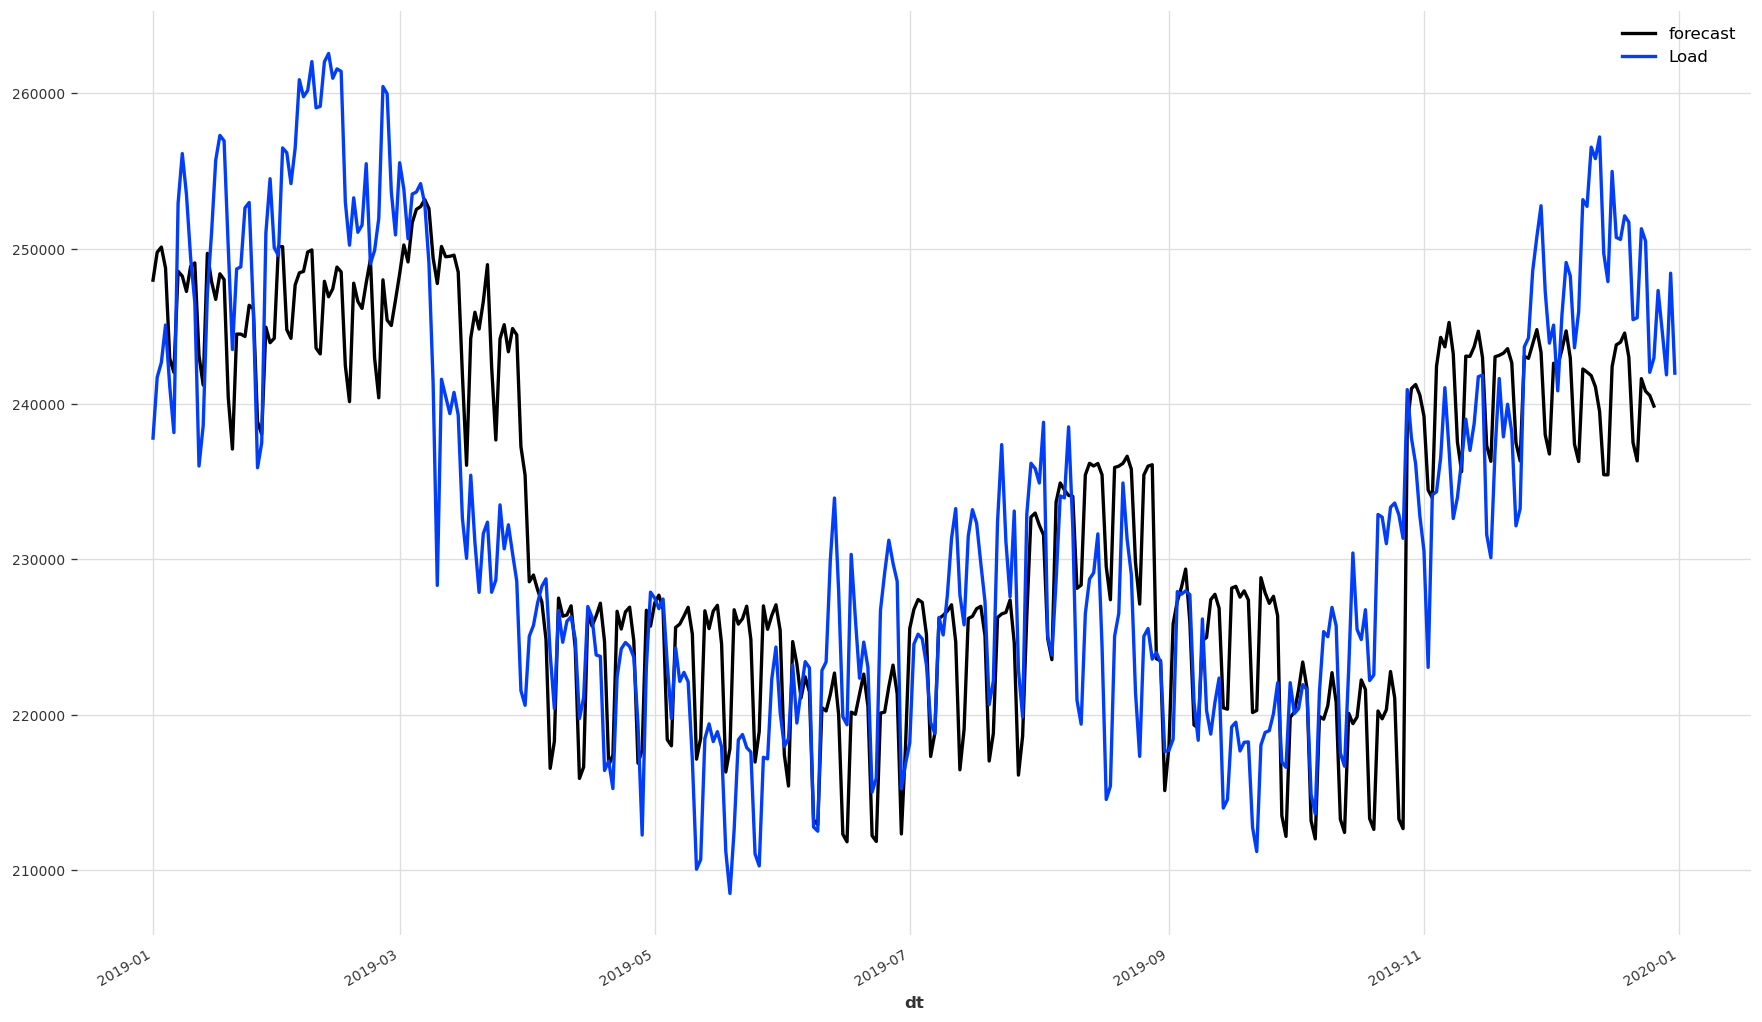

In [9]:
eval_results(RF)

In [10]:
XGB = XGBModel(
    lags=7,
    lags_future_covariates=(7,1),
    output_chunk_length=1,
    random_state=0,
)

XGB.fit(
    train,
    future_covariates=covariates,
    verbose=True,
)

  0%|          | 0/12 [00:00<?, ?it/s]

Total error (RMSE) over all historical forecasts: 4944.72
Average error (RMSE) over all historical forecasts: 4762.17


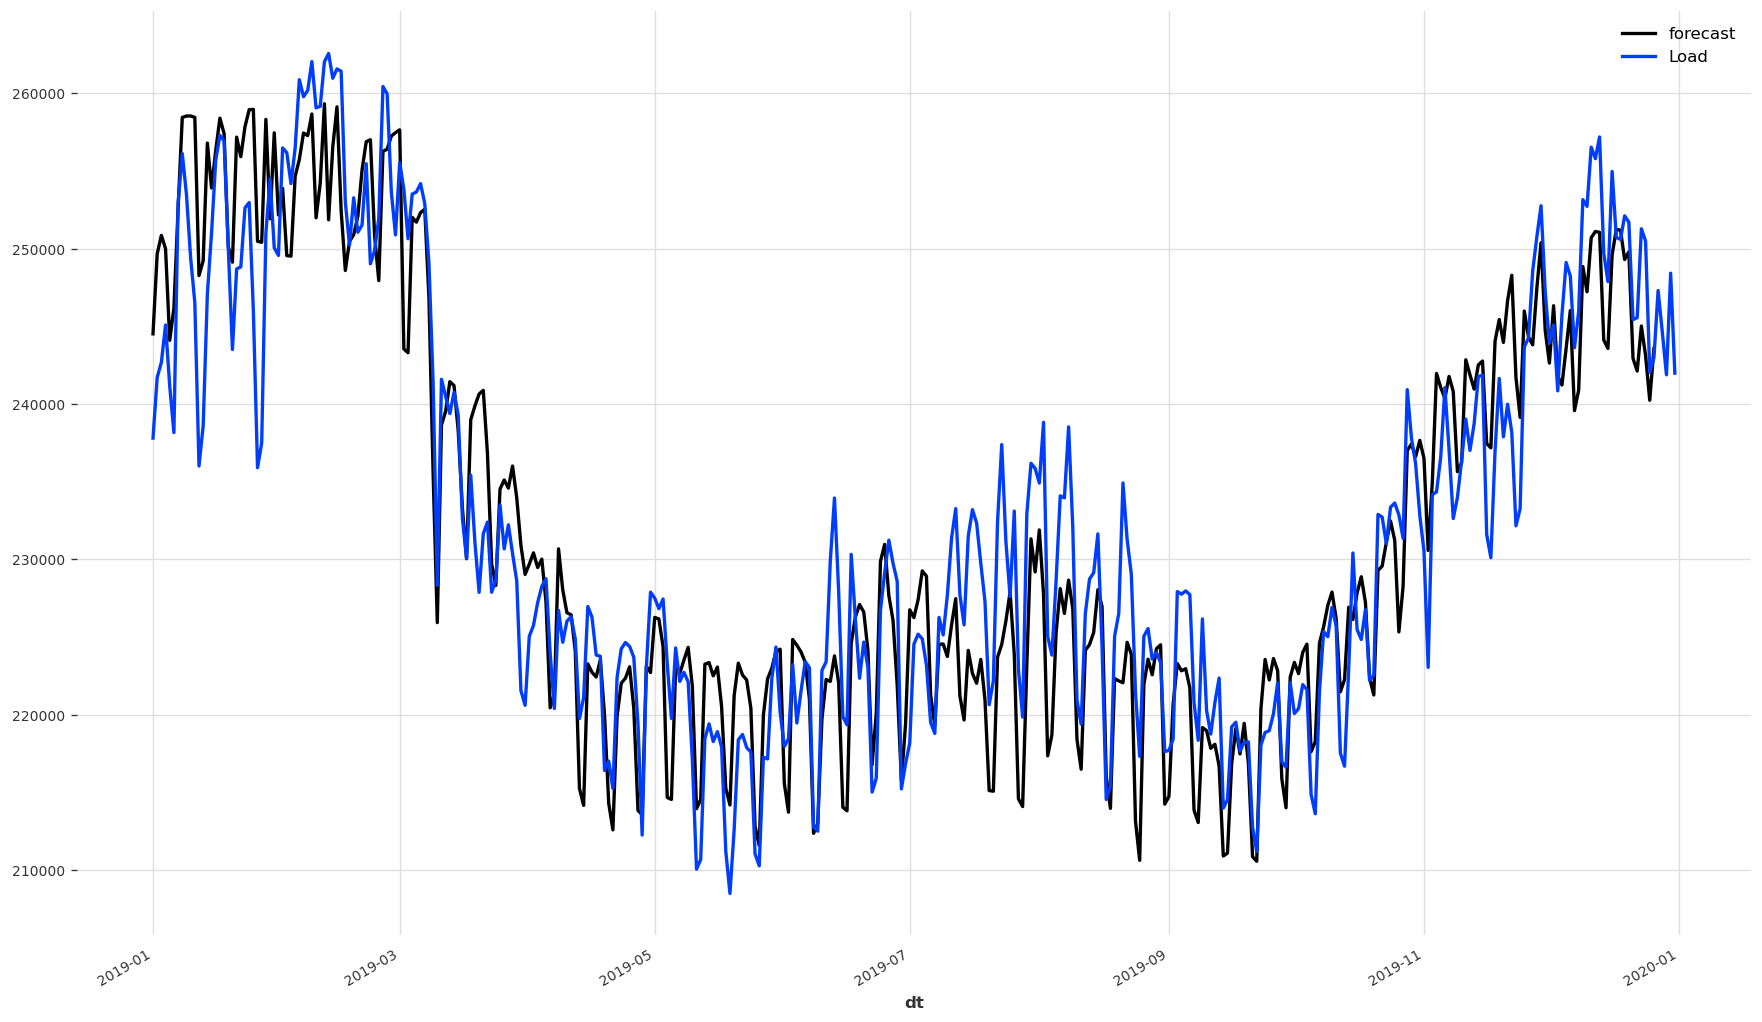

In [11]:
eval_results(XGB)

In [12]:
df_weather = pd.read_csv(r'weatherDaily.csv')
df_weather['Date'] = pd.to_datetime(df_weather['Date'])
Temp = TimeSeries.from_dataframe(df_weather, "Date",["MinTemp", "MaxTemp"])

covariates = covariates.stack(Temp)

  0%|          | 0/12 [00:00<?, ?it/s]

Total error (RMSE) over all historical forecasts: 4928.35
Average error (RMSE) over all historical forecasts: 4612.48


  0%|          | 0/12 [00:00<?, ?it/s]

Total error (RMSE) over all historical forecasts: 4254.91
Average error (RMSE) over all historical forecasts: 4087.16


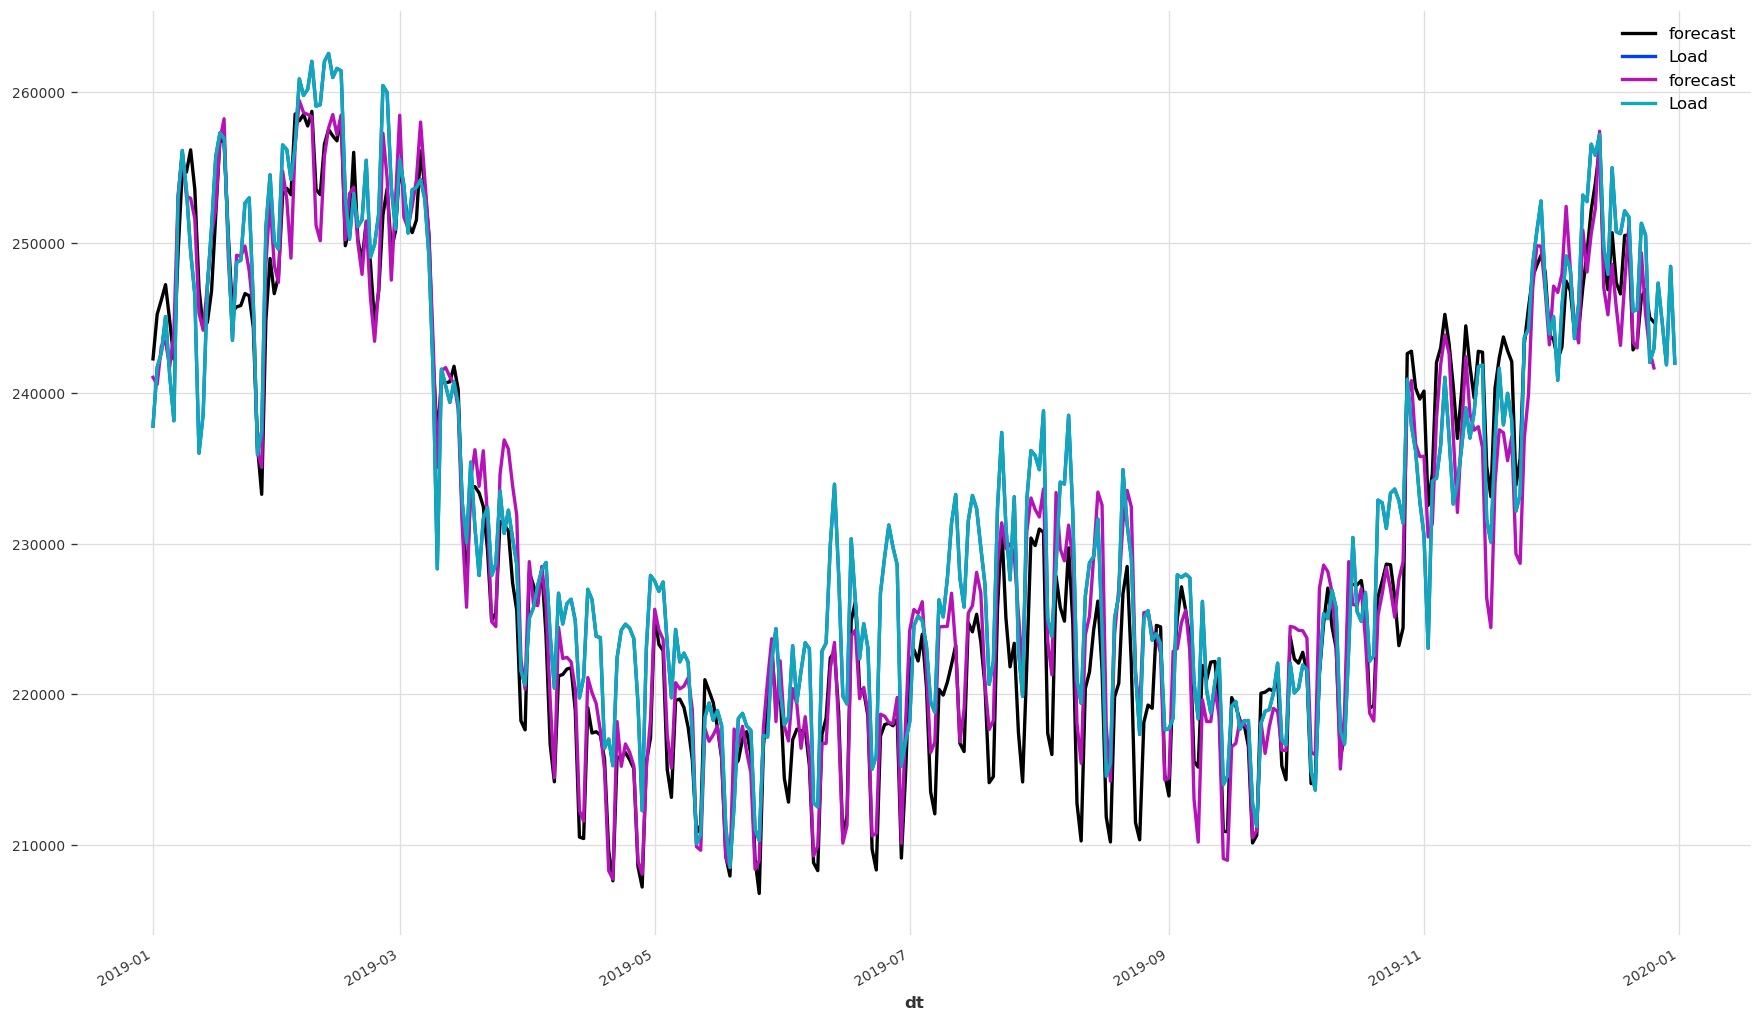

In [34]:
LGBModel = LightGBMModel(
    lags=7,
    lags_future_covariates=(7,1),
    output_chunk_length=1,
    random_state=0,
)


LGBModel.fit(
    train,
    future_covariates=covariates,
    verbose=True,
)
eval_results(LGBModel)

XGB = XGBModel(
    lags=7,
    lags_future_covariates=(7,1),
    output_chunk_length=1,
    random_state=0,
)

XGB.fit(
    train,
    future_covariates=covariates,
    verbose=True,
)

eval_results(XGB)

In [36]:
def eval_results_tune(model):
    backtest = model.historical_forecasts(
        train_val,
        future_covariates=covariates,
        start=pd.Timestamp("20180101"),
        forecast_horizon=30,
        stride=30,
        last_points_only = False,
        retrain=False,
        verbose=False
    )
    forecast = concatenate(backtest)
    error=[]
    for i in range(0,12):
        error.append(rmse(forecast[i*30:i*30+30], val[i*30:i*30+30], verbose=False))

    return np.mean(error)

In [72]:
def objective(trial):
    # set input_chunk_length, between 5 and 14 days
    in_len = trial.suggest_int("in_len", 1, 40)

    # set out_len, between 1 and 13 days (it has to be strictly shorter than in_len).
    #out_len = trial.suggest_int("out_len", 1, min(5, in_len))
    #cov_len = trial.suggest_int("cov_len", 1, 40)

    # build and train the TCN model with these hyper-parameters:
    model = XGBModel(
    lags=in_len,
    lags_future_covariates=(in_len,1),
    output_chunk_length=1,
    random_state=0,
    )

    model.fit(
        train,
        future_covariates=covariates,
        verbose=True,
    )

    return eval_results_tune(model)

In [73]:
study = optuna.create_study(direction="minimize")

study.optimize(objective, n_trials=50)

# Finally, print the best value and best hyperparameters:
print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

[I 2023-04-16 02:08:38,955] A new study created in memory with name: no-name-aa839cdb-8cd7-492c-b460-dab1b4f1d5b1
[I 2023-04-16 02:08:40,388] Trial 0 finished with value: 6000.647779347709 and parameters: {'in_len': 20, 'cov_len': 31}. Best is trial 0 with value: 6000.647779347709.
[I 2023-04-16 02:08:41,302] Trial 1 finished with value: 6351.187103539247 and parameters: {'in_len': 25, 'cov_len': 9}. Best is trial 0 with value: 6000.647779347709.
[I 2023-04-16 02:08:42,236] Trial 2 finished with value: 6763.310524133857 and parameters: {'in_len': 33, 'cov_len': 5}. Best is trial 0 with value: 6000.647779347709.
[I 2023-04-16 02:08:42,625] Trial 3 finished with value: 7225.556888836506 and parameters: {'in_len': 1, 'cov_len': 1}. Best is trial 0 with value: 6000.647779347709.
[I 2023-04-16 02:08:43,293] Trial 4 finished with value: 6224.91124349172 and parameters: {'in_len': 21, 'cov_len': 1}. Best is trial 0 with value: 6000.647779347709.
[I 2023-04-16 02:08:44,557] Trial 5 finished wi

Best value: 5755.365223950004, Best params: {'in_len': 29, 'cov_len': 20}


In [74]:
plot_optimization_history(study)

In [76]:
plot_contour(study, params=['in_len', 'cov_len'])

  0%|          | 0/12 [00:00<?, ?it/s]

Total error (RMSE) over all historical forecasts: 4254.91
Average error (RMSE) over all historical forecasts: 4087.16


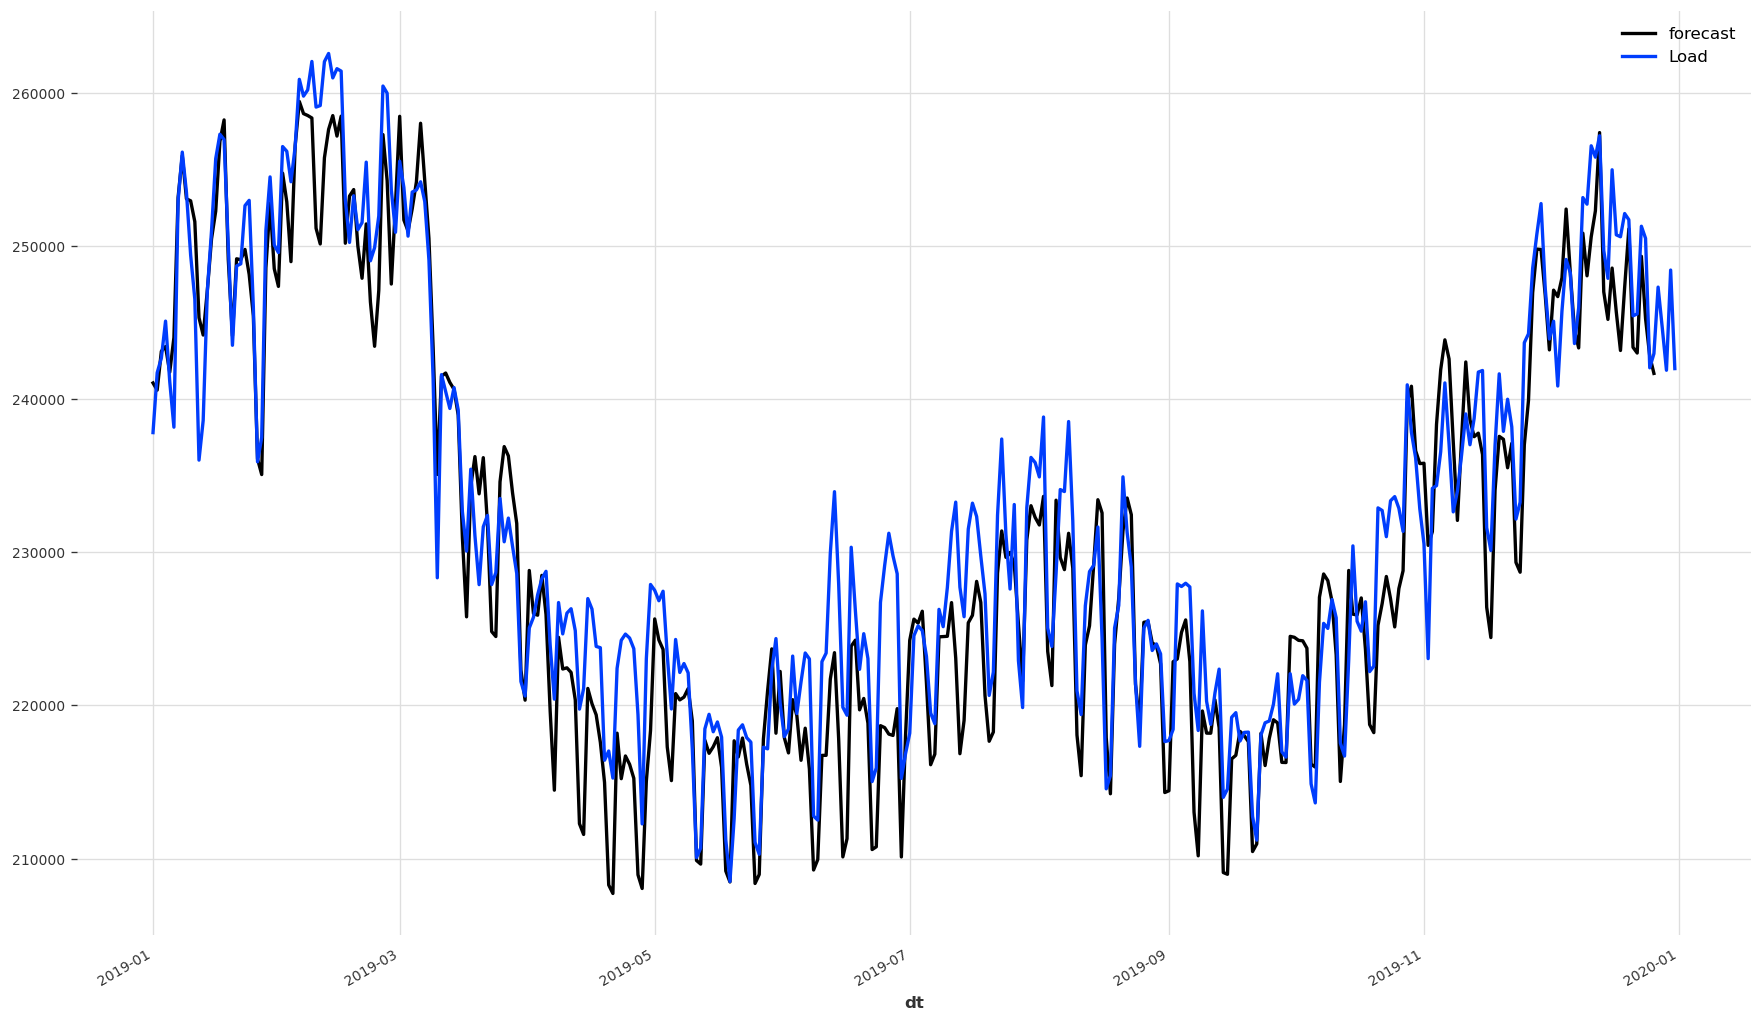

In [79]:
XGB = XGBModel(
    lags=30,
    lags_future_covariates=(30,1),
    output_chunk_length=1,
    random_state=0,
)

XGB.fit(
    train_val,
    future_covariates=covariates,
    verbose=True,
)

eval_results(XGB)